In [1]:
import os
import numpy as np
import pandas as pd
import gc
from datetime import datetime
from functools import partial
import xgboost as xgb
from tqdm import tqdm_notebook, tnrange
from scipy import signal
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 50
pd.options.mode.use_inf_as_na = True
pd.options.display.float_format = '{:.3f}'.format

rng = np.random.RandomState(datetime.now().microsecond)

In [2]:
DATA_PATH = r'~/lanl/data'
OUTPUT_FILENAME = 'quake_feats.pkl'
limit_rows = None   # total rows = 629145480

data = (pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), nrows=limit_rows,
                   dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
            .values)
print(f'input data shape: {data.shape}')

input data shape: (629145480, 2)


### Data
Inputs (X) consist of segments of waveform (i.e. a time series of amplitude measurements) that represents the vibrations of physical material, and is sampled at a rate of 4MHz.  Train data is one contiguous segment of ~630MM samples.  Test data are segments of length 150,000.

Here we plot a sample of the original waveform viewed at successive levels of magnification (on the time axis).  The macro features (first graph) appear as aperiodic pulses of varying magnitude.  Within the pulses (fourth graph), there appears to be a fairly regular sinusoid oscillation at roughly 1 cycle every 16 samples, corresponding to a frequency of 4MHz / 16 = 250kHz.

Outside of the pulses (last graph), the base pattern appears to be mostly noise.

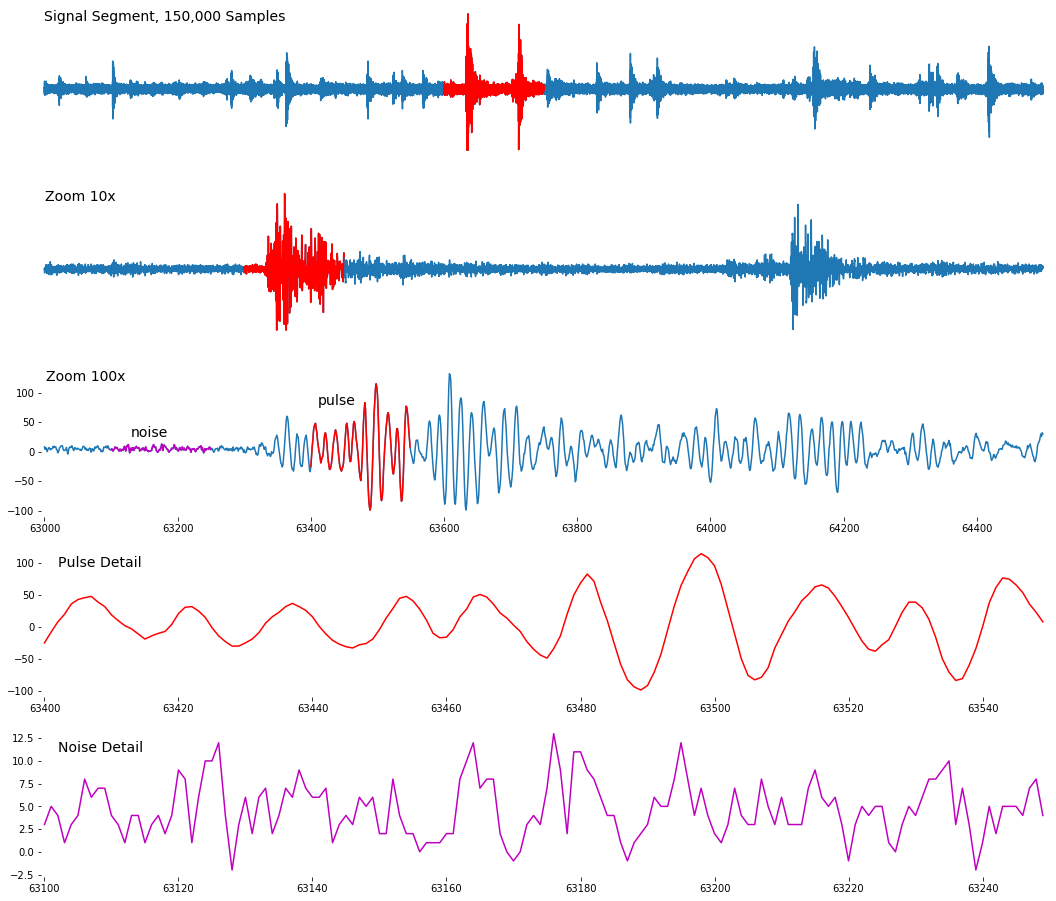

In [3]:
start = 130000000
t = np.arange(150000)

offset1, range1 = 60000, 15000
offset2, range2 = 63000, 1500
offset3, range3 = 63400, 150
noise_offset, noise_range = 63100, 150

fig = plt.figure(figsize=(18, 16))

ax = fig.add_subplot(5, 1, 1)
plt.plot(t, data[start:start+150000, 0])
plt.plot(t[offset1:offset1+range1], data[start+offset1:start+offset1+range1, 0], c='r')
ax.text(2, 120, 'Signal Segment, 150,000 Samples', fontsize=14)

ax = fig.add_subplot(5, 1, 2)
plt.plot(t[offset1:offset1+range1], data[start+offset1:start+offset1+range1, 0])
plt.plot(t[offset2:offset2+range2], data[start+offset2:start+offset2+range2, 0], c='r')
ax.text(offset1+2, 120, 'Zoom 10x', fontsize=14)

ax = fig.add_subplot(5, 1, 3)
plt.plot(t[offset2:offset2+range2], data[start+offset2:start+offset2+range2, 0])
plt.plot(t[offset3:offset3+range3], data[start+offset3:start+offset3+range3, 0], c='r')
plt.plot(t[noise_offset:noise_offset+noise_range],
         data[start+noise_offset:start+noise_offset+noise_range, 0], c='m')
ax.text(offset2+2, 120, 'Zoom 100x', fontsize=14)
ax.text(63130, 25, 'noise', fontsize=14)
ax.text(63410, 80, 'pulse', fontsize=14)

ax = fig.add_subplot(5, 1, 4)
plt.plot(t[offset3:offset3+range3], data[start+offset3:start+offset3+range3, 0], c='r')
ax.text(offset3+2, 95, 'Pulse Detail', fontsize=14)

ax = fig.add_subplot(5, 1, 5)
plt.plot(t[noise_offset:noise_offset+range3], data[start+noise_offset:start+noise_offset+range3, 0], c='m')
ax.text(noise_offset+2, 11, 'Noise Detail', fontsize=14)

for ax in fig.axes[:2]:
    ax.margins(x=0.003)
    ax.axis('off')

for ax in fig.axes[2:]:
    ax.margins(x=0.003)
    for s in ax.spines:
        ax.spines[s].set_visible(False);

### Labels
The label/target is "time to failure" (TTF), which is the amount of time until the next quake.  The training data is unbalanced: samples with TTF > 11 are relatively scarce. 

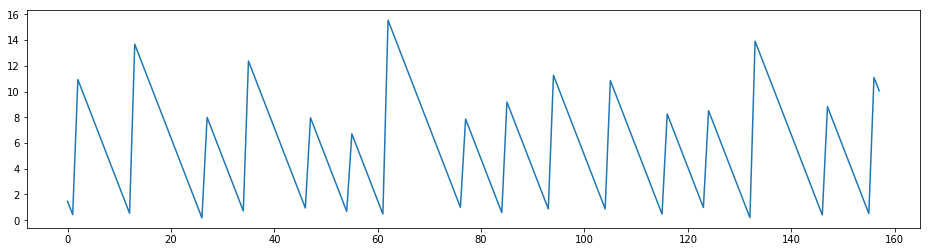

In [5]:
fig = plt.figure(figsize=(16,4))
plt.plot(y_train_raw[::1000000]);

### Downsampling
Use scipy.signal.decimate to downsample the raw waveform.  This reduces the compute time to process spectrograms.  decimate also applies an anti-aliasing (i.e. low-pass) filter that reduces the noise present at the highest frequencies.

In [4]:
def downsample(data, downsample_rate):
    trunc = int((data.shape[0] // downsample_rate) * downsample_rate)
    data = data[:trunc, :]
    x = signal.decimate(data[:, 0].ravel(), downsample_rate)
    y_ = data[:, 1].reshape((-1, downsample_rate)).T
    y = y_.mean(axis=0)
    return x, y

RAW_SEQ_LEN = 150000
DOWNSAMPLE_RATE = 4

assert (RAW_SEQ_LEN / DOWNSAMPLE_RATE) % 1 == 0
downsampled_seq_len = int(RAW_SEQ_LEN/DOWNSAMPLE_RATE)

X_train_raw, y_train_raw = downsample(data, DOWNSAMPLE_RATE)
del data

print(f'downsample rate: {DOWNSAMPLE_RATE}')
print(f'downsampled seq len: {downsampled_seq_len}')
print(f'X shape: {X_train_raw.shape} y shape: {y_train_raw.shape}')

downsample rate: 4
downsampled seq len: 37500
X shape: (157286370,) y shape: (157286370,)


### Spectrograms
Spectrograms sample a signal at regular intervals and convert the waveform into power measurements on a frequency scale.  In other words, it is a time series of Fourier Transforms.  The scipy.signal.spectrogram function generates spectrograms from signal data.

Parameters for the spectrogram function control the size of the sampling window, the type of convolution function ("window function") used for sampling, and other aspects of the FFT algorithm.  Several combinations of parameters were tested.  The logarithm of the power spectrum was used to generate features.

In [6]:
def spectrogram(sig_in, dsamp):
    nperseg = 128 # default 256
    noverlap = nperseg // 2 # default: nperseg // 8
    fs = 4000000 // dsamp # sampling frequency.  raw signal sample rate is 4MHz
    window = 'hann'
    scaling = 'density' # {'density', 'spectrum'}
    detrend = 'linear' # {'linear', 'constant', False}
    eps = 1e-11  # epsilon
    f, t, Sxx = signal.spectrogram(sig_in, nperseg=nperseg, noverlap=noverlap,
                                   fs=fs, window=window,
                                   scaling=scaling, detrend=detrend)
    return f, t, np.log(Sxx + eps)

Plot signal samples and their corresponding spectrograms:

spectrogram shape: (65, 584), size: 37960


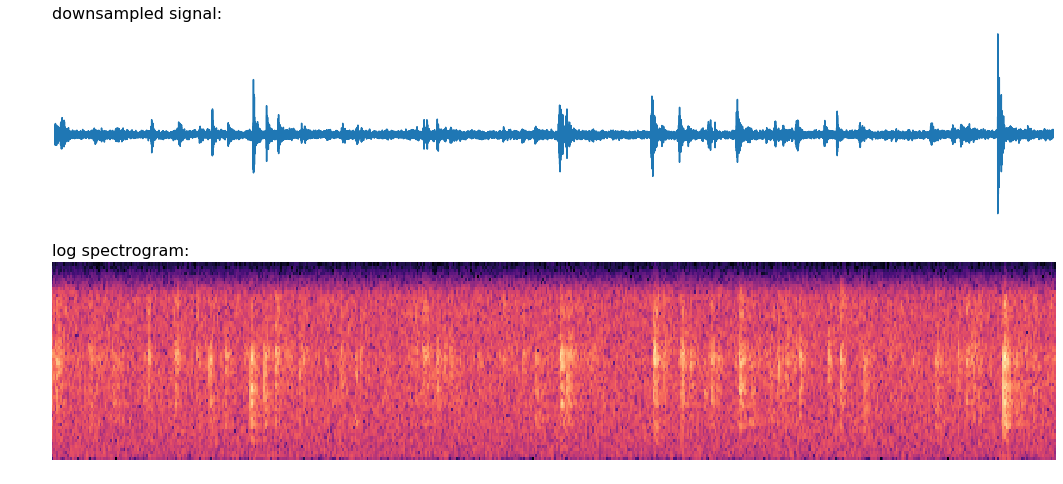

In [7]:
def plot_spec(sig_in):
    f, t, Sxx = spectrogram(sig_in, DOWNSAMPLE_RATE)
    print(f'spectrogram shape: {Sxx.shape}, size: {Sxx.size}')
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(2, 1, 1)
    ax.margins(x=0.003)
    plt.plot(sig_in)
    plt.title('downsampled signal:', fontsize=16, loc='left')
    plt.axis('off')
    ax = fig.add_subplot(2, 1, 2)
    cmap = plt.get_cmap('magma')
    spec = plt.pcolormesh(t, f, Sxx, cmap=cmap)
    plt.title('log spectrogram:',
              fontsize=16, loc='left')
    plt.axis('off');

start = rng.randint(0, X_train_raw.shape[0] - downsampled_seq_len)
sig_in = X_train_raw[start:start+downsampled_seq_len]
plot_spec(sig_in)

In [8]:
def get_Sxx_batch(source, n_samples, seq_len, dsamp_rate, mode=None):
    if source == 'train':
        X = X_train_; y = y_train_
    elif source == 'val':
        X = X_val_; y = y_val_
    else:
        X = source; y = [0]
    if source in ('train', 'val'):
        start_list = [rng.randint(0, X.shape[0]-seq_len)
                      for i in range(n_samples)]
    else:
        start_list = [0]
    X_batch = []
    for start in start_list:
        sig_in = X[start:start+seq_len]
        f, _, Sxx = spectrogram(sig_in, dsamp_rate)
        X_batch.append(Sxx)
    sxx_h, sxx_w = (X_batch[0].shape)
    X_batch = np.array(X_batch).reshape(n_samples, sxx_h, sxx_w)
    if source in ('train', 'val'):
        y_batch = [y[start+seq_len] for start in start_list]
    else:
        y_batch = [0]
    return X_batch, y_batch, f

### Features
Features generated from the spectrograms comprise two tiers of aggregations:

Tier 1: Aggregations across all frequency bands:
 - Range (max - min) was a more powerful predictor than standard deviation.
 - Mean scored low in feature importance and was not included.  The tier-2 features were more powerful than tier-1 mean.
 - 10 and 90 percentiles, and the range/difference between the percentiles improved CV scores.

Tier 2: Aggregations on individual frequency bands:
 - Mean and standard deviation
 - Quantiles/partitions within frequency band contributed most to accuracy.  Cut points were established by experimentation.  The most effective was top 4, then next 4, then next 8, 16, 32, etc.  In addition, the mean of the lowest 64 values were included.
 - Frequency-band quantiles in the 200kHz-300kHz range generated the most predictive power, corresponding to the resonant frequency range seen in the plots above.

In [9]:
def get_feats_batch(args_in):
    source, batch_size = args_in
    X_out, y_out = [], []
    X_batch, y_batch, freqs = get_Sxx_batch(
        source, batch_size, downsampled_seq_len, DOWNSAMPLE_RATE)
    Sxx_w = X_batch.shape[2]
    
    freqs = ['%03d' % (i/1000) for i in freqs]
    
    # aggregations
    X_2d = X_batch.reshape((batch_size, -1))
    X_out.append(pd.DataFrame(X_2d.mean(axis=1), columns=['mean_']))
    X_out.append(pd.DataFrame(X_2d.std(axis=1), columns=['std_']))
    max_ = pd.DataFrame(X_2d.max(axis=1), columns=['max_'])
    min_ = pd.DataFrame(X_2d.min(axis=1), columns=['min_'])
    range_ = pd.DataFrame((max_.values-min_.values), columns=['range_'])
    X_out.extend([min_, max_, range_])

    # quantiles
    q90 = pd.DataFrame(np.quantile(X_2d, 0.9, axis=1), columns=['q90_'])
    q10 = pd.DataFrame(np.quantile(X_2d, 0.1, axis=1), columns=['q10_'])
    range80 = pd.DataFrame((q90.values-q10.values), columns=['range80_'])
    X_out.extend([q90, q10, range80])
    
    # aggregations by frequency band.
    X_out.append(pd.DataFrame(X_batch.mean(axis=2), columns=freqs).add_prefix('mean_'))
    X_out.append(pd.DataFrame(X_batch.std(axis=2), columns=freqs).add_prefix('std_'))
    
    # partition the power levels in each frequency band by quantiles,
    # then generate the mean of each quantile
    top_k = (0, 4, 8, 16, 32, 64, 128) # cut points for the quantiles
    cp_inv = [Sxx_w - i for i in top_k][::-1]
    part = np.partition(X_batch, cp_inv[:-1], axis=2)
    
    t1 = (pd.DataFrame(part[:, :, cp_inv[-2]:cp_inv[-1]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[1]) + '_mean_'))

    t2 = (pd.DataFrame(part[:, :, cp_inv[-3]:cp_inv[-2]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[2]) + '_mean_'))
    
    t3 = (pd.DataFrame(part[:, :, cp_inv[-4]:cp_inv[-3]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[3]) + '_mean_'))

    t4 = (pd.DataFrame(part[:, :, cp_inv[-5]:cp_inv[-4]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[4]) + '_mean_'))

    t5 = (pd.DataFrame(part[:, :, cp_inv[-6]:cp_inv[-5]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[5]) + '_mean_'))

    t6 = (pd.DataFrame(part[:, :, cp_inv[-7]:cp_inv[-6]].mean(axis=2),
                      columns=freqs)
         .add_prefix('top_' + str(top_k[6]) + '_mean_'))

    # a final partition is the mean of the lowest power levels in the spectrogram    
    low64_mean = pd.DataFrame((np.partition(X_batch, 64, axis=2)[:, :, :64]
                              .mean(axis=2)),
                             columns=freqs)
    low64_mean = low64_mean.add_prefix('low64_mean_')
    
    X_out.extend([low64_mean, t6, t5, t4, t3, t2, t1])
    
    X_out = pd.concat(X_out, axis=1)
    y_out = pd.Series(y_batch)
    return (X_out, y_out)

Divide the training data into 5 folds, and generate random samples from each of the folds, for a total of 500,000 training features:

In [10]:
def joblib_map(func, args, n_jobs=None, prefer='threads', verbose=10):
    from joblib import Parallel, delayed
    output = Parallel(n_jobs=n_jobs, prefer=prefer, verbose=verbose)(
    (delayed(func)(arg) for arg in args))
    return output

def get_feats_parallel(source, n_samples, batch_size=500, n_jobs=8):
    print('n_tasks =', n_samples // batch_size)
    targs = [(source, batch_size) for i in range(n_samples // batch_size)]
    feats = joblib_map(get_feats_batch, targs, n_jobs=n_jobs)
    X_out = pd.concat([batch[0] for batch in feats], axis=0)
    y_out = pd.concat([batch[1] for batch in feats])
    return X_out, y_out

N_FOLDS = 5
train_samples = 500000
interval = X_train_raw.shape[0] / N_FOLDS
splits = [int(interval * i) for i in range(N_FOLDS+1)]

X_folds, y_folds = [], []
for fold in range(N_FOLDS):
    X_train_ = X_train_raw[splits[fold]:splits[fold+1]]
    y_train_ = y_train_raw[splits[fold]:splits[fold+1]]
    print(f'building fold {fold+1} of {N_FOLDS}...')
    X_train, y_train = get_feats_parallel(
        'train', train_samples//N_FOLDS, n_jobs=8)
    X_train['fold'] = int(fold + 1)
    X_folds.append(X_train)
    y_folds.append(y_train)
X_train = pd.concat(X_folds, axis=0, ignore_index=True)
y_train = pd.concat(y_folds, ignore_index=True)
print('X_train.shape:', X_train.shape)

building fold 1 of 5...
n_tasks = 200


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   26.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   27.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   50.8s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.4min
[Para

building fold 2 of 5...
n_tasks = 200


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   27.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   28.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   57.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  6.2min
[Para

building fold 3 of 5...
n_tasks = 200


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   27.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   50.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.9min
[Para

building fold 4 of 5...
n_tasks = 200


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   55.7s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.8min
[Para

building fold 5 of 5...
n_tasks = 200


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   59.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  6.2min
[Para

X_train.shape: (500000, 594)


The resulting dataset comprises 593 features (last column is a fold designator):

In [11]:
print(f'X_train size: {X_train.memory_usage().sum()/1000000000:.3f}GB')
print(f'shape {X_train.shape}')
X_train.head()

X_train size: 2.376GB
shape (500000, 594)


,mean_,std_,min_,max_,range_,q90_,q10_,range80_,mean_000,mean_007,mean_015,mean_023,mean_031,mean_039,mean_046,mean_054,mean_062,mean_070,mean_078,mean_085,mean_093,mean_101,mean_109,mean_117,mean_125,mean_132,mean_140,mean_148,mean_156,mean_164,mean_171,mean_179,mean_187,mean_195,mean_203,mean_210,mean_218,mean_226,mean_234,mean_242,mean_250,mean_257,mean_265,mean_273,mean_281,mean_289,mean_296,mean_304,mean_312,mean_320,mean_328,mean_335,mean_343,mean_351,mean_359,mean_367,mean_375,mean_382,mean_390,mean_398,mean_406,mean_414,mean_421,mean_429,mean_437,mean_445,mean_453,mean_460,mean_468,mean_476,mean_484,mean_492,mean_500,std_000,std_007,std_015,std_023,std_031,std_039,std_046,std_054,std_062,std_070,std_078,std_085,std_093,std_101,std_109,std_117,std_125,std_132,std_140,std_148,std_156,std_164,std_171,std_179,std_187,std_195,std_203,std_210,std_218,std_226,std_234,std_242,std_250,std_257,std_265,std_273,std_281,std_289,std_296,std_304,std_312,std_320,std_328,std_335,std_343,std_351,std_359,std_367,std_375,std_382,std_390,std_398,std_406,std_414,std_421,std_429,std_437,std_445,std_453,std_460,std_468,std_476,std_484,std_492,std_500,low64_mean_000,low64_mean_007,low64_mean_015,low64_mean_023,low64_mean_031,low64_mean_039,low64_mean_046,low64_mean_054,low64_mean_062,low64_mean_070,low64_mean_078,low64_mean_085,low64_mean_093,low64_mean_101,low64_mean_109,low64_mean_117,low64_mean_125,low64_mean_132,low64_mean_140,low64_mean_148,low64_mean_156,low64_mean_164,low64_mean_171,low64_mean_179,low64_mean_187,low64_mean_195,low64_mean_203,low64_mean_210,low64_mean_218,low64_mean_226,low64_mean_234,low64_mean_242,low64_mean_250,low64_mean_257,low64_mean_265,low64_mean_273,low64_mean_281,low64_mean_289,low64_mean_296,low64_mean_304,low64_mean_312,low64_mean_320,low64_mean_328,low64_mean_335,low64_mean_343,low64_mean_351,low64_mean_359,low64_mean_367,low64_mean_375,low64_mean_382,low64_mean_390,low64_mean_398,low64_mean_406,low64_mean_414,low64_mean_421,low64_mean_429,low64_mean_437,low64_mean_445,low64_mean_453,low64_mean_460,low64_mean_468,low64_mean_476,low64_mean_484,low64_mean_492,low64_mean_500,top_128_mean_000,top_128_mean_007,top_128_mean_015,top_128_mean_023,top_128_mean_031,top_128_mean_039,top_128_mean_046,top_128_mean_054,top_128_mean_062,top_128_mean_070,top_128_mean_078,top_128_mean_085,top_128_mean_093,top_128_mean_101,top_128_mean_109,top_128_mean_117,top_128_mean_125,top_128_mean_132,top_128_mean_140,top_128_mean_148,top_128_mean_156,top_128_mean_164,top_128_mean_171,top_128_mean_179,top_128_mean_187,top_128_mean_195,top_128_mean_203,top_128_mean_210,top_128_mean_218,top_128_mean_226,top_128_mean_234,top_128_mean_242,top_128_mean_250,top_128_mean_257,top_128_mean_265,top_128_mean_273,top_128_mean_281,top_128_mean_289,top_128_mean_296,top_128_mean_304,top_128_mean_312,top_128_mean_320,top_128_mean_328,top_128_mean_335,top_128_mean_343,top_128_mean_351,top_128_mean_359,top_128_mean_367,top_128_mean_375,top_128_mean_382,top_128_mean_390,top_128_mean_398,top_128_mean_406,top_128_mean_414,top_128_mean_421,top_128_mean_429,top_128_mean_437,top_128_mean_445,top_128_mean_453,top_128_mean_460,top_128_mean_468,top_128_mean_476,top_128_mean_484,top_128_mean_492,top_128_mean_500,top_64_mean_000,top_64_mean_007,top_64_mean_015,top_64_mean_023,top_64_mean_031,top_64_mean_039,top_64_mean_046,top_64_mean_054,top_64_mean_062,top_64_mean_070,top_64_mean_078,top_64_mean_085,top_64_mean_093,top_64_mean_101,top_64_mean_109,top_64_mean_117,top_64_mean_125,top_64_mean_132,top_64_mean_140,top_64_mean_148,top_64_mean_156,top_64_mean_164,top_64_mean_171,top_64_mean_179,top_64_mean_187,top_64_mean_195,top_64_mean_203,top_64_mean_210,top_64_mean_218,top_64_mean_226,top_64_mean_234,top_64_mean_242,top_64_mean_250,top_64_mean_257,top_64_mean_265,top_64_mean_273,top_64_mean_281,top_64_mean_289,top_64_mean_296,top_64_mean_304,top_64_mean_312,top_64_mean_320,top_64_mean_328,top_64_mean_335,top_64_mean_343,top_64_mean_351,top_64_mean_359,top_64_mean_367

### Re-weighting/Augmenting Training Data

Initial CV results exhibit a fair amount of underfitting at the far ends of the labels, i.e. TTF values above 11 and below 1, most likely reflecting the imbalance of the training data.  To address the imbalance, we augment the training data by duplicating training samples outside the range of 1.0-11.0.  Augmentation/upsampling resulted in modest improvements in CV results.

In [12]:
high_cutoff = 11
low_cutoff = 1
augment_rate = 1

def augment_train(X_train, y_train):
    high_idx = y_train[y_train>high_cutoff].index
    low_idx = y_train[y_train<low_cutoff].index
    print('high', len(high_idx), 'low', len(low_idx), 'total', len(high_idx) + len(low_idx))
    X_high = X_train.loc[high_idx, :]
    X_low = X_train.loc[low_idx, :]
    y_high = y_train.loc[high_idx]
    y_low = y_train.loc[low_idx]
    X_augment = [X_high] * augment_rate + [X_low] * augment_rate
    y_augment = [y_high] * augment_rate + [y_low] * augment_rate
    X_augment = pd.concat(X_augment, axis=0, ignore_index=True)
    y_augment = pd.concat(y_augment, ignore_index=True)
    return X_augment, y_augment

X_augment, y_augment = augment_train(X_train, y_train)
print('X_augment', X_augment.shape, 'y_augment', y_augment.shape)
X_train = pd.concat([X_train, X_augment], axis=0, ignore_index=True)
y_train = pd.concat([y_train, y_augment], ignore_index=True)
del X_augment; del y_augment
print(f'X_train size: {X_train.memory_usage().sum()/1000000000:.3f}GB, ' +
     f'X_train.shape: {X_train.shape}')

high 47142 low 48887 total 96029
X_augment (96029, 594) y_augment (96029,)
X_train size: 2.832GB, X_train.shape: (596029, 594)


Generate features from the test dataset:

In [13]:
test_path = os.path.join(data_path, 'test')
files = os.listdir(test_path)
print('total files', len(files)) # 2624
preds = {'seg_id': [], 'time_to_failure': []}
feats_list = []
for fname in tqdm_notebook(files):
    path = os.path.join(test_path, fname)
    obs = np.array(pd.read_csv(path).values)
    data = np.c_[obs, np.zeros(len(obs))]
    x, y = downsample(data, DOWNSAMPLE_RATE)
    (feats, _) = get_feats_batch((x, 1))
    seg_id = fname.split('.')[0]
    feats['seg_id'] = seg_id
    feats_list.append(feats)
    
X_test = pd.concat(feats_list, axis=0).reset_index(drop=True)

total files 2624


In [12]:
import pickle
with open(os.path.join(DATA_PATH, OUTPUT_FILENAME), 'wb') as file:
    pickle.dump([X_train, y_train, X_test], file)